In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_csv('results_circle.csv', sep=';')
df_all.head()

,myproc,p,n,time
0,5,10,1000000,0.915967
1,3,10,1000000,0.922183
2,2,10,1000000,0.929037
3,7,10,1000000,0.970425
4,4,10,1000000,0.919532


## Ускорение и закон Амдаля

In [3]:
for myproc in df_all.myproc.unique():
    for n in df_all.n.unique():
        for p in df_all.p.unique():
            df_all.loc[(df_all.p==p)&(df_all.n==n),'mean_time'] = df_all[(df_all.p==p)&(df_all.n==n)]['time'].mean()

In [4]:
df = df_all[df_all.myproc == 0]

In [5]:
for n in df.n.unique():
    for p in df.p.unique():
        p_1_time = (df[(df.n==n)&(df.p==1)]['mean_time']).iloc[0]
        own_time = df[(df.p==p)&(df.n==n)]['mean_time'].iloc[0]
        df.loc[(df.p==p)&(df.n==n),'accel'] = p_1_time/own_time

/Users/a.kozharin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/a.kozharin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
df['eff'] = df['accel']/df['p']

/Users/a.kozharin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
def amdal(p, f):
    return 1/(f + (1-f)/p)

In [8]:
def plot_save_graphs(x_label, y_label, fixed='p'):
    
    def _appr_accel(n, p):
        return 6*n/(6*n/p + 6 + np.log2(p))
    
    def _appr_eff(n, p):
        return _appr_accel(n, p)/p
    
    def _appr_amdal(n, p, accels):
        if len(np.array(p).reshape(-1)) == 1:
            p = np.array([p]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(p))
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(amdal, p, accels)
        return amdal(p, popt[0])
    
    def _routine(data, x_label, y_label, fixed_value):
        x_data, y_data = data[x_label], data[y_label]
        plt.scatter(x_data, y_data, label='real')
        p, n = (fixed_value, x_data)
        if x_label == 'p':
            p, n = (n, p)
        # Approximation
        if y_label == 'accel':
            plt.scatter(x_data, _appr_accel(n, p), color='red', label='theor')
            if x_label == 'p':
                plt.scatter(x_data, _appr_amdal(n, p, y_data), color='green', label='amdal')
        elif y_label == 'eff':
            plt.scatter(x_data, _appr_eff(n, p), color='red', label='theor')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(f'{y_label}, {fixed}={fixed_value}')
        plt.savefig(f'{y_label}_{fixed}_{fixed_value}', dpi=120)
        plt.show()
    if fixed == 'n':
        for n in df.n.unique():
            data = df[df.n==n]
            _routine(data, x_label, y_label, n)
    elif fixed == 'p':
        for p in df.p.unique():
            data = df[df.p==p]
            _routine(data, x_label, y_label, p)
    else:
        raise ValueError('Not implemented')

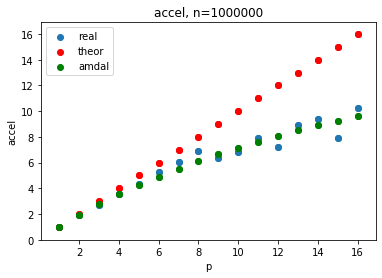

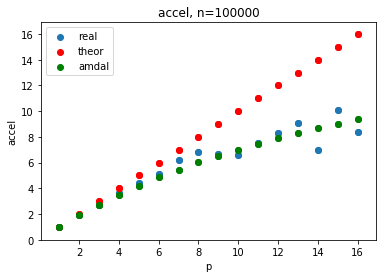

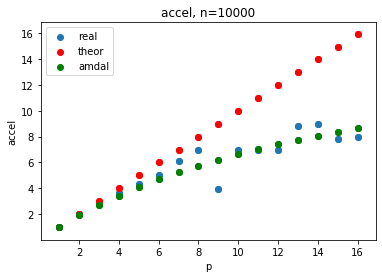

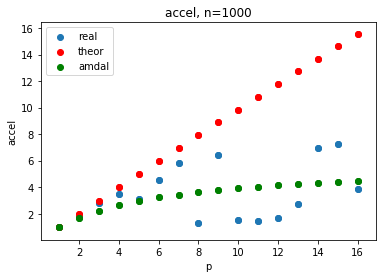

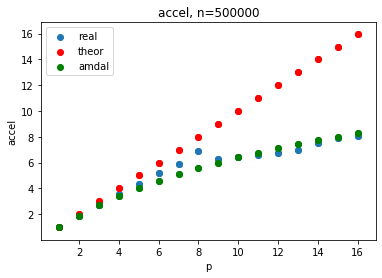

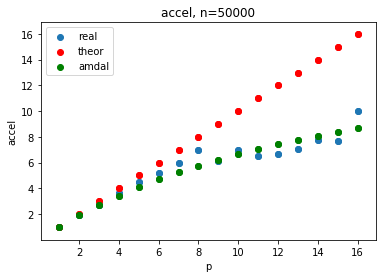

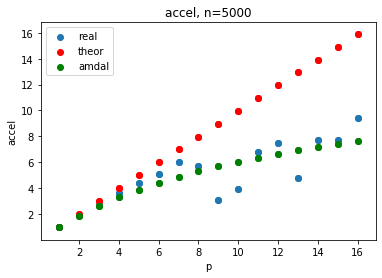

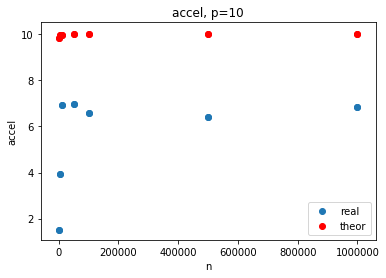

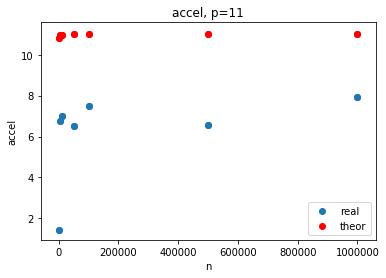

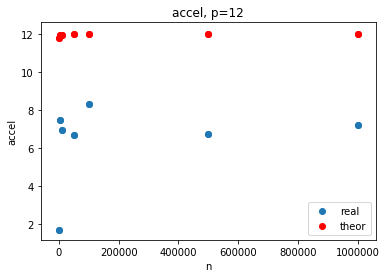

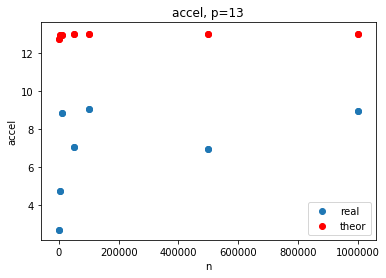

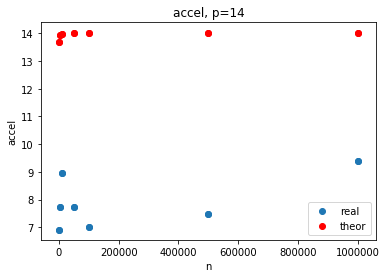

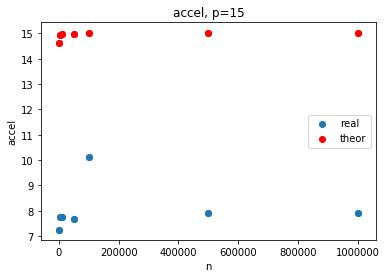

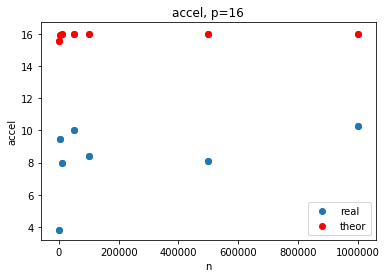

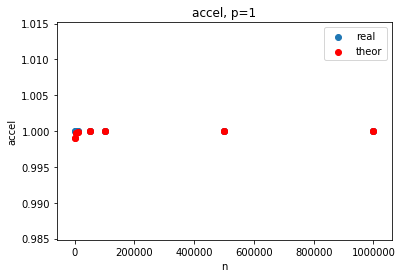

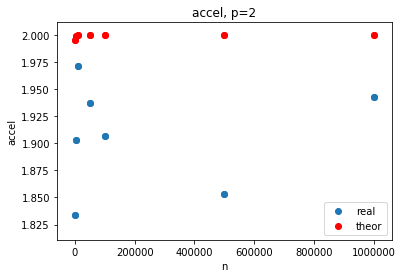

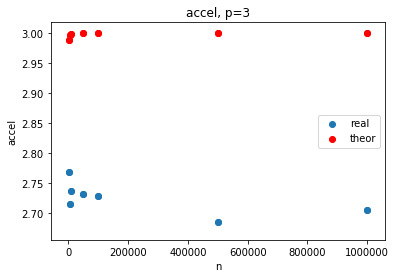

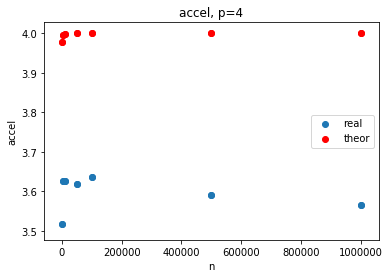

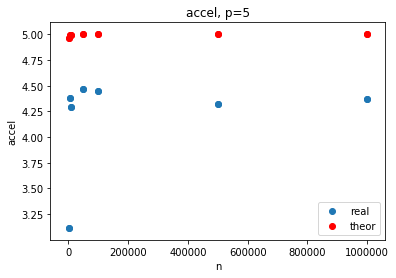

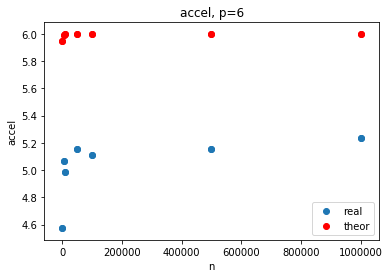

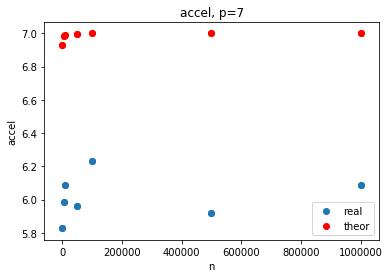

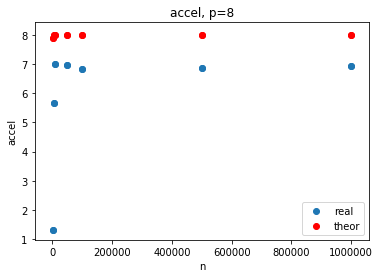

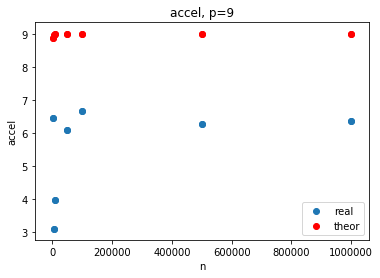

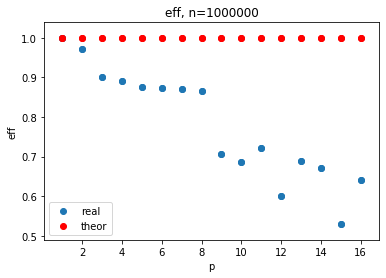

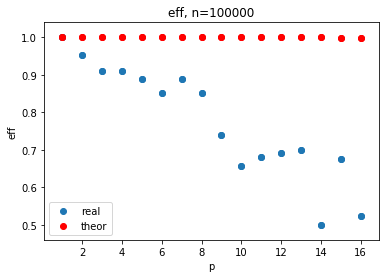

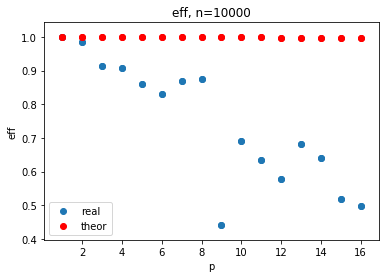

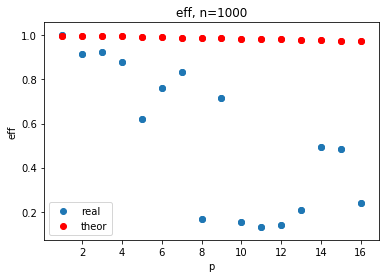

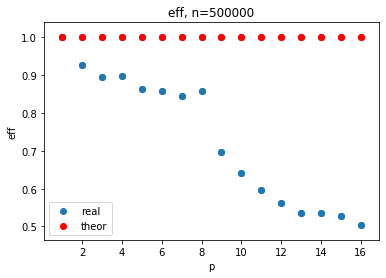

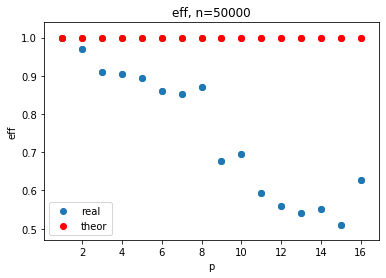

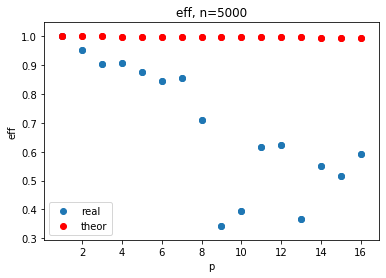

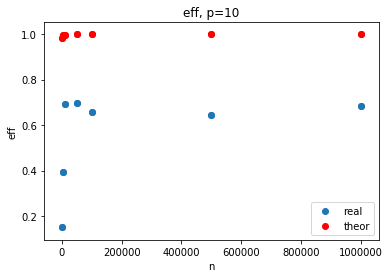

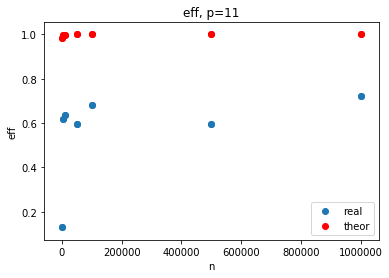

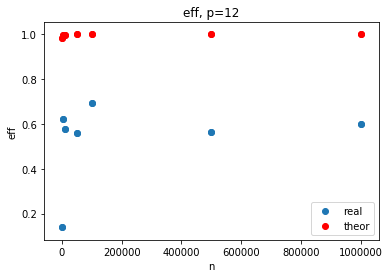

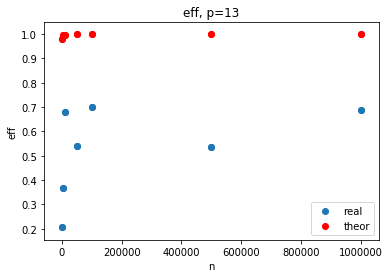

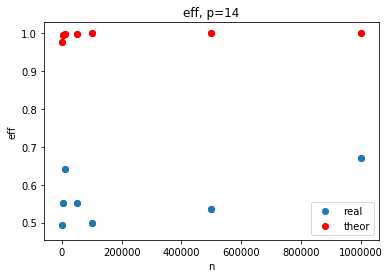

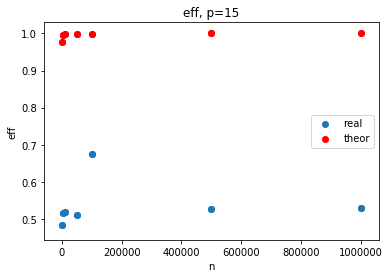

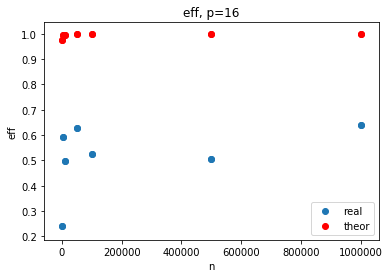

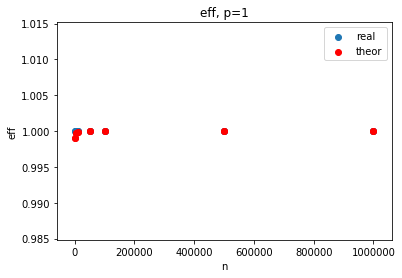

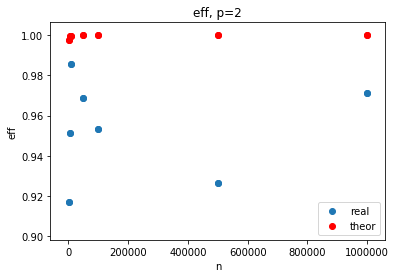

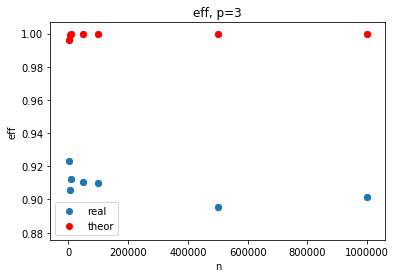

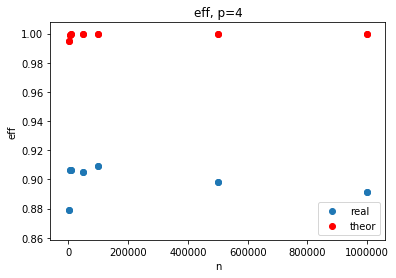

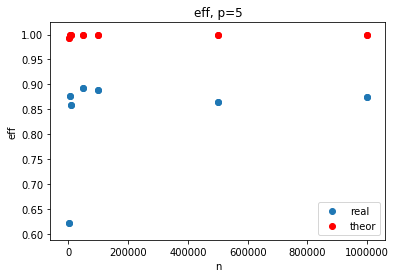

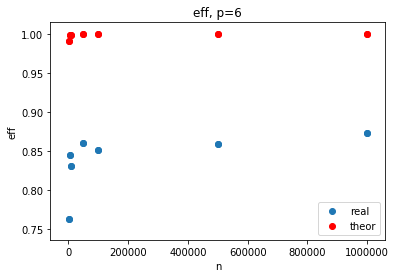

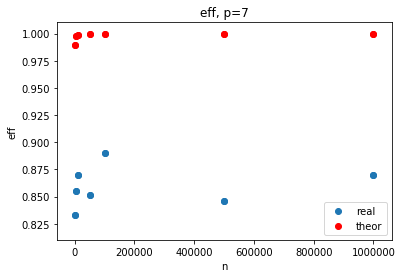

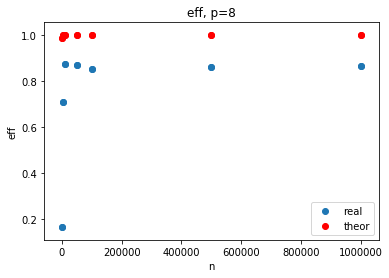

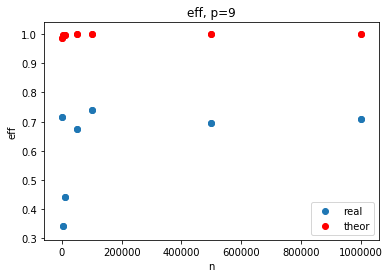

In [9]:
plot_save_graphs('p', 'accel', fixed='n')
plot_save_graphs('n', 'accel', fixed='p')
plot_save_graphs('p', 'eff', fixed='n')
plot_save_graphs('n', 'eff', fixed='p')

## Распределение времени работы каждого процесса

In [10]:
for n in df_all.n.unique():
    for p in df_all.p.unique():
        for myproc in df_all.myproc.unique():
            own_time = df_all.loc[(df_all.p == p)&(df_all.n == n)&(df_all.myproc == myproc),'time']
            if len(own_time) == 0:
                continue
            own_time = own_time.iloc[0]
            p0_time = df_all.loc[(df_all.p == p)&(df_all.n == n)&(df_all.myproc == 0),'time'].iloc[0]
            df_all.loc[(df_all.p == p)&(df_all.n == n)&(df_all.myproc == myproc),'delay'] = p0_time - own_time

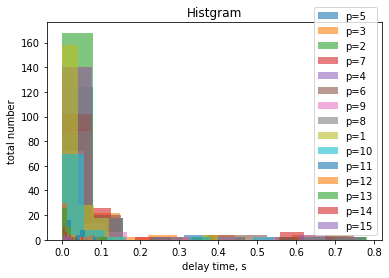

In [11]:
for p in df_all.myproc.unique():
    if p == 0:
        continue
    plt.xlabel('delay time, s')
    plt.ylabel('total number')
    plt.title(f'Histgram')
    plt.hist(df_all[df_all.myproc == p]['delay'], alpha=0.6, label=f'p={p}')
    plt.legend()
plt.savefig('delay_histogram.png', dpi=120)

Время задержки - примерно 0.1 секунда.

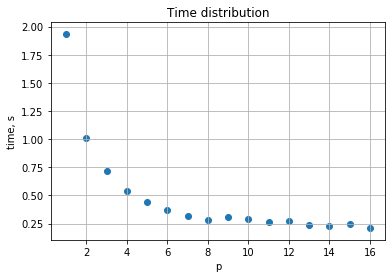

In [12]:
plt.xlabel('p')
plt.ylabel('time, s')
plt.scatter(df_all['p'].unique(), [df_all.loc[df_all.p == p,'time'].mean() for p in df_all.p.unique()])
plt.title('Time distribution')
plt.grid()

## Сравнение для двух способов разбиения

In [13]:
df_circle = pd.read_csv('results_circle.csv', sep=';')
df_parts = pd.read_csv('results.csv', sep=';')

In [14]:
df_circle.head()

,myproc,p,n,time
0,5,10,1000000,0.915967
1,3,10,1000000,0.922183
2,2,10,1000000,0.929037
3,7,10,1000000,0.970425
4,4,10,1000000,0.919532


In [15]:
df_delta = df_circle.copy()
for myproc in df_circle.myproc.unique():
    for p in df_circle.p.unique():
        for n in df_circle.n.unique():
            df_circle_time = df_circle.loc[(df_circle.n == n)&(df_circle.p == p)&(df_circle.myproc == myproc),'time'].mean()
            df_parts_time = df_parts.loc[(df_parts.n == n)&(df_parts.p == p)&(df_parts.myproc == myproc),'time'].mean()
            df_delta.loc[(df_delta.n == n)&(df_delta.p == p)&(df_delta.myproc == myproc),'delta'] = df_circle_time - df_parts_time

In [16]:
print('From circle to parts')
print('time increased: {} times'.format(np.count_nonzero(df_delta.delta >= 0)))
print('time decreased: {} times'.format(np.count_nonzero(df_delta.delta < 0)))

From circle to parts
time increased: 1310 times
time decreased: 594 times


Видим, что время подсчета увеличилось.